In [1]:
"""
import necessary modules
"""
import numpy as np
from dorna2 import Dorna
from camera import Camera
from dorna_vision import Detection
import time
import util

"""
parameters
"""
robot_ip_address = "192.168.254.87" # robot ip address
output_config = {
    "pick_init":[0, 0, 0],
    "decap_init": [1, 0, 0],
    "gripper": [0, 1, 0],
    "decap": [1, 1, 0],
    "pick": [0, 1, 1],
    "barcode": [0, 1, 1],
    "decap_place": [0, 1, 0],
}
tcp = {
    "5ml_cap": [0, 0, 53, 0, 0, 90],
    "15ml_cap":[0, 0, 43, 0, 0, 90],
    "50ml_cap": [0, 0, 53, 0, 0, 90],
}

decap_round = {
    "5ml_cap": 8,
    "15ml_cap": 8,
    "50ml_cap": 6,
}

imaging_joint = [90.175781, 79.958496, -108.325195, 0.219727, -67.456055, 0]
middle_joint = imaging_joint

# decap
decap_position = {
    "5ml_cap": [161.921621, 278.731741, 140, 127, -127, 0],
    "15ml_cap":[141.401519, 275.304174, 140, 127, -127, 0],
    "50ml_cap": [167.466961, 275.26108, 140, 127, -127, 0],
}

cap_drop_pose = [258, 57, 140, 180, 0, 0]

barcode_pose = [323.088207, 293.246132, 140, 127, -127, 0]

speed_pick = 0.5 # here set the speed of the robot
above = 130
motion = "lmove"
sim=0
freedom = {"num": 50, "range": [2, 2, 2], "early_exit": False}

# detection parameters
detection_parameters = {
    "camera_mount":{
        "type": "dorna_ta_j4",
        "ej": [0 ,0,0, 0, 0, 0, 0, 0],
        "T": [46.5174596+1+1, 32.0776662-3+1-0, -4.24772615, -0.27547989, 0.27691881, 89.6939516],
        #"T": [46.5174596, 32.0776662, -4.24772615, -0.27547989, 0.27691881, 89.6939516]
    },
    'detection': {'cmd': 'od', 'path': 'tube.pkl', 'conf': 0.1, 'cls': []}, 
    'limit': {'area': [0, 100000], 'aspect_ratio': [0.9, 1.0], 'xyz': [[-140, 110], [200, 420], [110, 140]], 'inv': 0}, 
    'output': {'max_det': 20, 'shuffle': True, 'save_img': True, 'save_img_roi': True}
    }

# grasp
rvec_base = [180, 0, 0]
padding = 5 # pixel
gripper_opening = 50 #mm

In [2]:
"""
initialize the robot, camera, and object detection
"""
robot = Dorna() # initialize robot
robot.connect(robot_ip_address) # connect to robot

camera = Camera() # initialize camera
camera.connect() # connect to camera

detection = Detection(camera=camera, robot=robot, **detection_parameters) # initialize the object detection

"""
init robot
"""
robot.set_output(output_config["pick_init"][0], output_config["pick_init"][1]) # set output
robot.set_output(output_config["decap_init"][0], output_config["decap_init"][1]) # set output
robot.set_motor(1) # turn on the robot motors
robot.sleep(1) # sleep to allow the robot to settle before moving

print(robot.jmove(imaging_joint))  #set safe initial position

"""
run the object detection and pick and place
"""
for i in range(1):  # range is set to 5 because we have 5 chips
    # always run this to make sure that the rbot is stationary before running the object detection
    time.sleep(0.1)

    s = time.time()
    # run the object detection
    result = detection.run()
    img_1 = detection.img.copy()
    
    # assign tcp to each pose
    for r in result:
        if r["cls"] in tcp:
            r["tcp"] = tcp[r["cls"]]
    
    # best pick
    best_pick_result = util.best_pick(result, rvec_base, detection.camera_data["joint"], robot, detection.frame_mat_inv, camera.camera_matrix(detection.camera_data["depth_int"]), camera.dist_coeffs(detection.camera_data["depth_int"]), padding, gripper_opening)
    

    if best_pick_result is not None:
        pick_pose, label, start, end, pose_valid_list, pose_not_valid_list = best_pick_result
        break
        # tcp
        robot.kinematic.set_tcp_xyzabc(tcp[label])

        # second detection
        second_img_pose = list(pick_pose)
        second_img_pose[2] += above/2
        #second_img_pose[1] += -40
        second_img_joint = robot.kinematic.inv(second_img_pose, detection.camera_data["joint"], False,freedom=freedom)[0]
        second_img_joint[5] = 0

        # go above
        robot.jmove(second_img_joint[0:6])
        
        # run the object detection
        time.sleep(0.1)
        result = detection.run()
        for r in result:
            if np.linalg.norm(np.array(r["xyz"]) - np.array(pick_pose[0:3])) < 10:
                pick_pose[0:3] = r["xyz"]
                # this executes the pick-and-place operation
                retval_pick = robot.pick_n_place(
                    pick_pose=pick_pose, # pick position we got from detection
                    place_pose=barcode_pose, # place poistion which we got from the class
                    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                    speed=speed_pick, # speed which we also defined in the cfg cell
                    output_config = output_config["pick"], # output in order (pin, off state, on state)
                    above=above,
                    motion=motion,
                    sim=sim,
                    )

                # barcode
                barcode_result = util.barcode_read(robot)

                # go to decap
                result = robot.pick_n_place(
                    place_pose=decap_position[label], # place poistion which we got from the class
                    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                    speed=speed_pick, # speed which we also defined in the cfg cell
                    output_config = output_config["decap_init"], # output in order (pin, off state, on state)
                    above=above,
                    motion=motion,
                    sim=sim,
                    )
                
                # decap
                util.decap(robot, label, output_config["gripper"], output_config["decap"], decap_position, tcp, decap_round[label])

                # drop_cap
                result = robot.pick_n_place(
                    place_pose=cap_drop_pose, # place poistion which we got from the class
                    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                    speed=speed_pick, # speed which we also defined in the cfg cell
                    output_config = output_config["gripper"], # output in order (pin, off state, on state)
                    above=above/2,
                    motion=motion,
                    sim=sim,
                    )

                # pick_vial and drop
                result = robot.pick_n_place(
                    pick_pose = np.array(decap_position[label])+np.array([0, 0, -23, 0, 0, 0]),
                    place_pose=pick_pose, # place poistion which we got from the class
                    end_joint=imaging_joint,
                    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                    speed=speed_pick, # speed which we also defined in the cfg cell
                    output_config = output_config["gripper"], # output in order (pin, off state, on state)
                    above=above,
                    motion=motion,
                    pick_cmd_list=[{"cmd":"output", "out"+str(output_config["decap"][0]): output_config["decap"][2], "queue":0}],
                    sim=sim,
                )


robot.close() # close robot
camera.close() # close camera
detection.close() # close object detection

2.0
0.18090510368347168


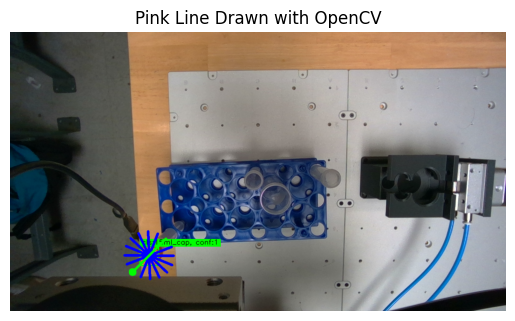

In [3]:
# try_1:  [343.5424054361505, -208.54841173866896, 120.96906205162398]

# "x":345.550535,"y":-208.05732,"z":164.920105
import matplotlib.pyplot as plt
import cv2 as cv

# draw start end
img = img_1.copy()

color = (255, 105, 180)  # Pink line

# Define thickness of the line
thickness = 5

# good
for p in pose_valid_list:
    cv.line(img, p[1], p[2], (255, 0, 0), thickness)



# bad
for p in pose_not_valid_list:
    cv.line(img, p[1], p[2], (0, 0, 255), thickness)

# best
cv.line(img, start, end, (0, 255, 0), thickness)
cv.circle(img, start, 10, (0, 255, 0), -1)


# Convert BGR to RGB for Matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)


plt.imshow(img_rgb)
plt.title("Pink Line Drawn with OpenCV")
plt.axis("off")  # Turn off axis
plt.show()

In [13]:
decap_position = {
    "5ml_cap": [161.921621, 278.731741, 140, 127, -127, 0],
    "15ml_cap":[141.401519, 275.304174, 140, 127, -127, 0],
    "50ml_cap": [167.466961, 275.26108, 140, 127, -127, 0],
}

# {"cmd":"lmove","rel":0,"x":141.47273,"y":275.002343,"z":161.695565,"a":179.967363,"b":0.188359,"c":-0.629325}
t = "15ml_cap"
robot = Dorna()
robot.connect(robot_ip_address)
sim = 0
# start
robot.jmove([54.55, 63.85, -104, 0, -50, -34])
robot.set_output(output_config["pick"][0], output_config["pick"][2])
robot.set_output(output_config["pick"][0], output_config["pick"][1]) # set output


# drop
robot.go((np.array(place_position[t])+np.array([0, 0, above, 0, 0, 0])).tolist(), tcp=tcp[t], motion="jmove", sim=sim)
robot.go(place_position[t], tcp=tcp[t], motion="lmove", sim=sim)
robot.set_output(output_config["pick"][0], output_config["pick"][2])


# approach
robot.go((np.array(place_position[t])+np.array([0, 0, -23, 0, 0, 0])).tolist(), tcp=tcp[t], motion="jmove", sim=sim)

#hold
robot.set_output(output_config["decap"][0], output_config["decap"][1]) # set output
for i in range(7):
    robot.set_output(output_config["pick"][0], output_config["pick"][1]) # close
    robot.lmove(rel=1, z=1.1, a=-307.278746,b=-127.253498, vel=500, accel=4000, jerk=10000) # rotate
    #dehold
    robot.set_output(output_config["pick"][0], output_config["pick"][2]) # open
    robot.jmove(rel=1, j5=90, vel=200, accel=2000, jerk=6000) # rotate


"""
# grab the cap
#robot.go((np.array(place_position[t])+np.array([0, 0, -15, 0, 0, 0])).tolist(), tcp=tcp[t], motion="jmove", sim=sim)
robot.set_output(output_config["pick"][0], output_config["pick"][1]) # close
robot.go((np.array(place_position[t])+np.array([0, 0, 20, 0, 0, 0])).tolist(), tcp=tcp[t], motion="jmove", sim=sim)
robot.jmove(cap_drop_joint)
robot.set_output(output_config["pick"][0], output_config["pick"][2]) # open
robot.set_output(output_config["decap"][0], output_config["decap"][2]) # open
"""

robot.close()



True

In [21]:
robot = Dorna()
robot.connect(robot_ip_address)

#robot.jmove(cap_drop_joint)
label = "15ml_cap"
result = robot.pick_n_place(
                            pick_pose = np.array(decap_position[label])+np.array([0, 0, -23, 0, 0, 0]),
                            place_pose=pick_pose, # place poistion which we got from the class
                            end_joint=imaging_joint,
                            tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                            speed=speed_pick, # speed which we also defined in the cfg cell
                            output_config = output_config["gripper"], # output in order (pin, off state, on state)
                            above=above,
                            motion=motion,
                            pick_cmd_list=[{"cmd":"output", "out"+str(output_config["decap"][0]): output_config["decap"][2], "queue":0}],
                            sim=sim,
)

robot.close()

[ 57.62019286 382.89052276 252.50462692 176.54135047 -35.11625796
   0.        ] [53.99987440128157, 66.90195171841191, -101.06284325034483, 0.074309589697567, -56.22914700152603, 53.95835746368269]


True

In [ ]:
s = {"cmd":"output", "out"+str(output_config["decap"][0]): output_config["decap"][2], "queue":0}

In [19]:
s

{'cmd': 'ouput', 'out1': 0, 'queue': 0}

In [3]:
0.18090510368347168 *50

9.045255184173584